

```
# This is formatted as code
```

# Session 13

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/S13/

/content/drive/MyDrive/S13


In [3]:
repo_name = "erav2s13"
git_repo_url = "https://huggingface.co/spaces/akutty/erav2s13"
branch_name= "main"


In [4]:
!rm -rf "{repo_name}" && ! git clone "{git_repo_url}"
    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
!cd "{repo_name}" && git checkout {branch_name}

Cloning into 'erav2s13'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 26), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (60/60), 616.96 KiB | 442.00 KiB/s, done.
Already on 'main'
Your branch is up to date with 'origin/main'.


In [5]:
%ls

 checkpoints/   data/   erav2s13/   logs/  'main(1).ipynb'


In [6]:
%cd erav2s13


/content/drive/MyDrive/S13/erav2s13


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [7]:
import sys
    # https://lightning.ai/docs/pytorch/stable/
!{sys.executable} -m pip install -q lightning
    # https://github.com/davidtvs/pytorch-lr-finder
!{sys.executable} -m pip install -q torch-lr-finder
    # https://github.com/tyleryep/torchinfo
!{sys.executable} -m pip install -q torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
!{sys.executable} -m pip install -q grad-cam
    # https://www.gradio.app/
!{sys.executable} -m pip install -q gradio
    # https://github.com/tensorflow/tensorboard
!{sys.executable} -m pip install -q tensorboard

In [8]:
import matplotlib.pyplot as plt
import torch
from lightning_fabric.utilities.seed import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
import tensorboard
from tqdm.auto import tqdm

In [9]:
%ls

app.py  models/  modules/  README.md  S13.ipynb


In [10]:
# Import user defined modules
import modules.config as config
from models.custom_resnet import CustomResNet as Net
from models.custom_resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES
from modules.lightning_dataset import CIFARDataModule
from modules.trainer import train_and_test_model
from modules.utils import get_num_workers, pretty_print_metrics
from modules.visualize import (
    plot_gradcam_images,
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

In [11]:
data_path = config.DATA_PATH
checkpoint_path = config.CHECKPOINT_PATH
logging_path = config.LOGGING_PATH

# Specify the number of epochs
num_epochs = config.NUM_EPOCHS

# Set the batch size
batch_size = config.BATCH_SIZE

# Set seed value for reproducibility
seed = config.SEED

In [12]:
model_run_location = "colab"
num_workers = get_num_workers(model_run_location)

# https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision("medium")

print(
    f"Run location: {model_run_location}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {batch_size} \n",
    f"Seed: {seed} \n",
    f"Data path: {data_path} \n",
    f"Logging path: {logging_path} \n",
    f"Checkpoint path: {checkpoint_path}",
)

seed_everything(seed)



INFO:lightning_fabric.utilities.seed:Seed set to 53


Run location: colab, 
 Number of workers: 2, 
 Batch size: 512 
 Seed: 53 
 Data path: ../../data/ 
 Logging path: ../../logs/ 
 Checkpoint path: ../../checkpoints/


53

In [13]:
cifar_data_module = CIFARDataModule(data_path=data_path, batch_size=batch_size, seed=seed, num_workers=num_workers)
# cifar_data_module = CIFARDataModule(data_path=data_path, batch_size=batch_size, seed=seed, num_workers=0)
cifar_data_module.prepare_data()
cifar_data_module.setup()

# Extract the train and test dataloaders
# train_loader = cifar_data_module.training_dataset
# val_loader = cifar_data_module.validation_dataset
# test_loader = cifar_data_module.testing_dataset

train_loader = cifar_data_module.train_dataloader()
val_loader = cifar_data_module.val_dataloader()
test_loader = cifar_data_module.test_dataloader()

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")


Files already downloaded and verified
Files already downloaded and verified
Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


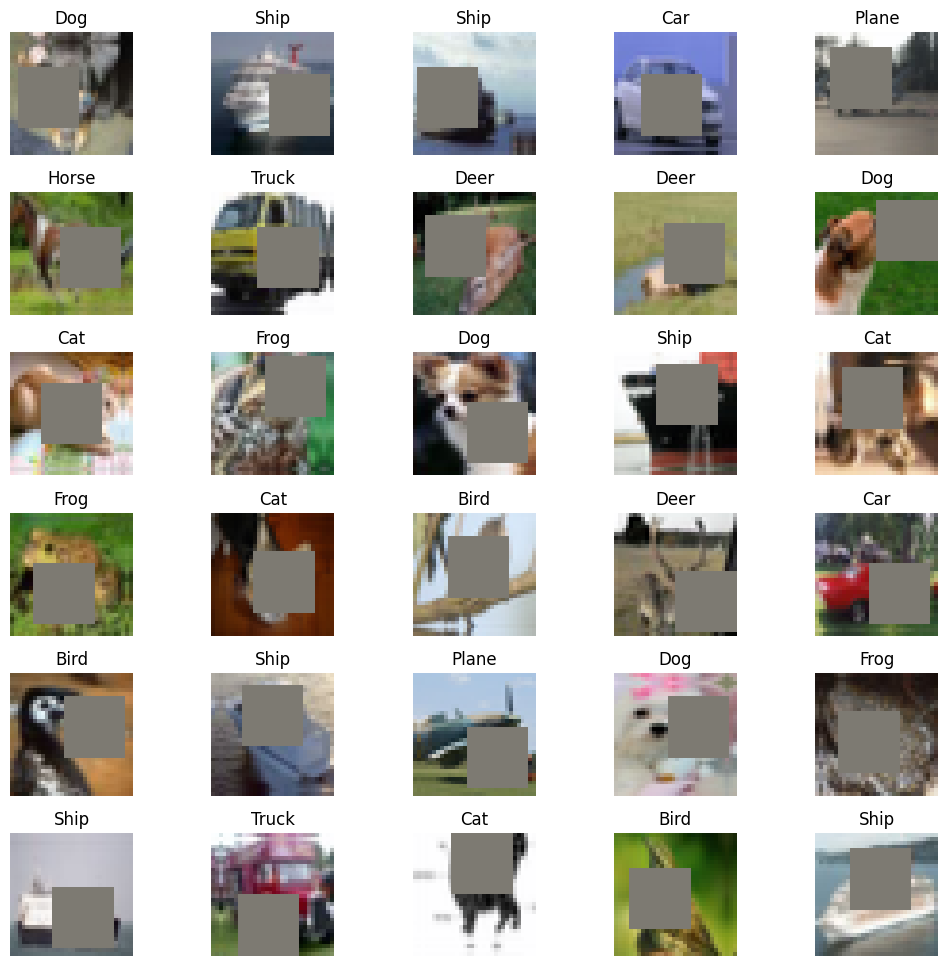

In [14]:
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

In [15]:
# Define the model
# No need to send the model to device as we are using the LightningModule
model = Net()

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 2 
	 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
	 torch.Size([1, 512, 4, 4]) 

Max Pooling 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  

In [16]:
logger = TensorBoardLogger(save_dir=logging_path, name="lightning_logs", log_graph=False)

In [17]:
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for num_epochs
trainer, results, misclassified_image_data = train_and_test_model(
    batch_size=batch_size,
    num_epochs=num_epochs,
    model=model,
    datamodule=cifar_data_module,
    logger=logger,
    # Alert: Change this when running in production
    debug=False,
)



Batch size: 512, Total epochs: 24


Defining Lightning Callbacks
Defining Lightning Trainer


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding the optimal learning rate using Lightning Tuner.
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/drive/MyDrive/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 4 steps due to diverging loss.
ERROR:pytorch_lightning.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/S13/erav2s13/.lr_find_899908d2-406a-49ff-9

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test ended! Saving misclassified images


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     91.5199966430664      │
│         test_loss         │    0.2885625660419464     │
└───────────────────────────┴───────────────────────────┘

Saving the model.
Model saved to ../../CustomResNet.pt
Folder path: ../..
Saving first 20 misclassified images.
Folder path: ../..


# Model Initialization & Summary

In [18]:
print(type(results))
print(results)
print(results.keys())
print(results["train_loss"])

<class 'dict'>
{'train_loss': [21.73940086364746, 1.597331166267395, 1.1019726991653442, 0.9527544379234314, 0.8206701874732971, 0.7856320738792419, 0.7091265320777893, 0.6186497211456299, 0.5599020719528198, 0.4926811456680298, 0.45813995599746704, 0.4195902943611145, 0.381695032119751, 0.35549095273017883, 0.31980037689208984, 0.28752562403678894, 0.26203039288520813, 0.23159083724021912, 0.2074798196554184, 0.18456079065799713, 0.1617870181798935, 0.13749951124191284, 0.1192043349146843, 0.09911727905273438, 0.0906842052936554], 'train_acc': [9.66796875, 43.073997497558594, 60.913997650146484, 66.41799926757812, 71.15999603271484, 72.43399810791016, 75.34600067138672, 78.3759994506836, 80.45800018310547, 82.73999786376953, 83.79999542236328, 85.26599884033203, 86.42599487304688, 87.48600006103516, 88.68399810791016, 89.78599548339844, 90.65599822998047, 91.82999420166016, 92.65599822998047, 93.45199584960938, 94.39199829101562, 95.20399475097656, 95.9219970703125, 96.73799896240234,

Plotting accuracy and loss graphs.


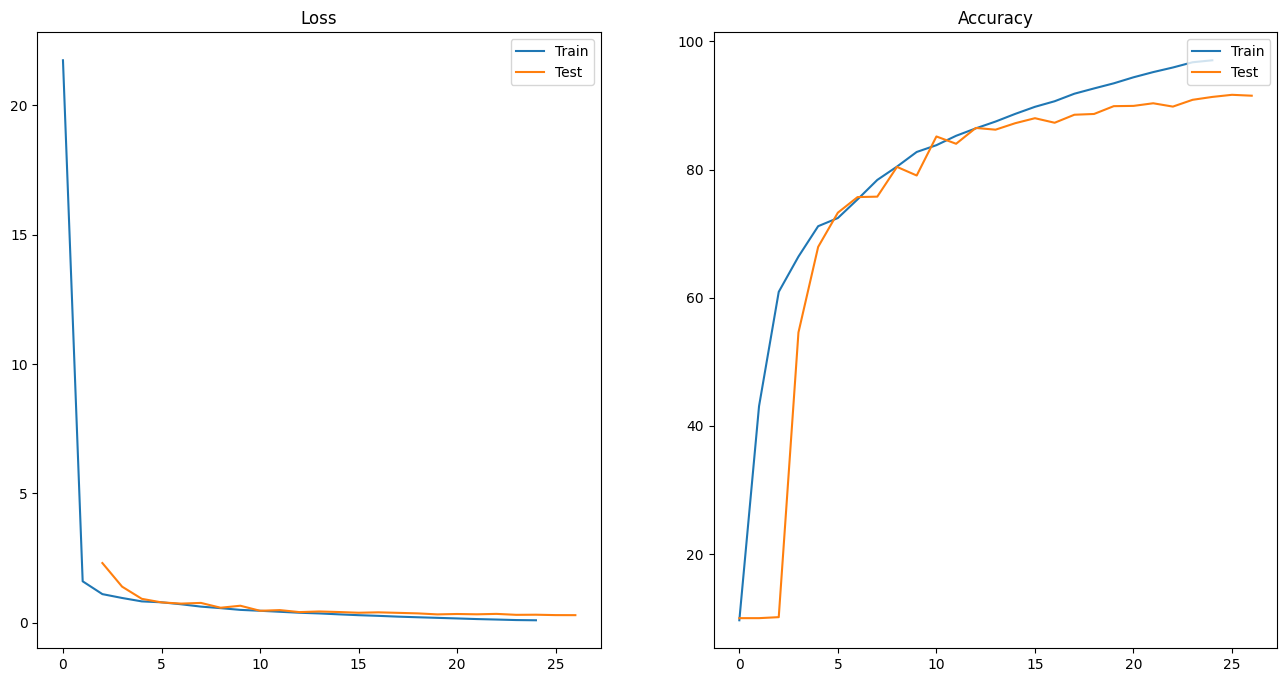

In [19]:
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()

In [20]:
pretty_print_metrics(num_epochs=num_epochs, results=results)

Epoch: 01, Train Loss: 21.7394, Test Loss: 2.3039, Train Accuracy: 9.6680, Test Accuracy: 10.0000
Epoch: 02, Train Loss: 1.5973, Test Loss: nan, Train Accuracy: 43.0740, Test Accuracy: 10.0000
Epoch: 03, Train Loss: 1.1020, Test Loss: 2.3034, Train Accuracy: 60.9140, Test Accuracy: 10.1562
Epoch: 04, Train Loss: 0.9528, Test Loss: 1.3907, Train Accuracy: 66.4180, Test Accuracy: 54.5800
Epoch: 05, Train Loss: 0.8207, Test Loss: 0.9200, Train Accuracy: 71.1600, Test Accuracy: 67.9300
Epoch: 06, Train Loss: 0.7856, Test Loss: 0.7821, Train Accuracy: 72.4340, Test Accuracy: 73.2700
Epoch: 07, Train Loss: 0.7091, Test Loss: 0.7352, Train Accuracy: 75.3460, Test Accuracy: 75.7000
Epoch: 08, Train Loss: 0.6186, Test Loss: 0.7620, Train Accuracy: 78.3760, Test Accuracy: 75.7700
Epoch: 09, Train Loss: 0.5599, Test Loss: 0.5754, Train Accuracy: 80.4580, Test Accuracy: 80.4100
Epoch: 10, Train Loss: 0.4927, Test Loss: 0.6533, Train Accuracy: 82.7400, Test Accuracy: 79.0700
Epoch: 11, Train Loss: 

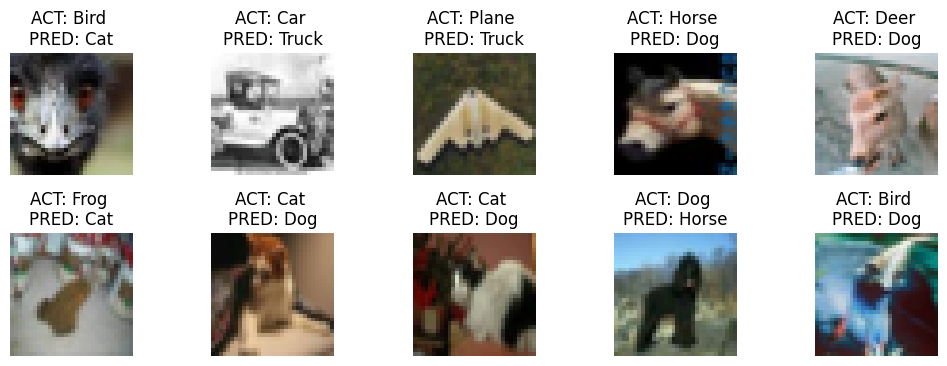

In [21]:
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()

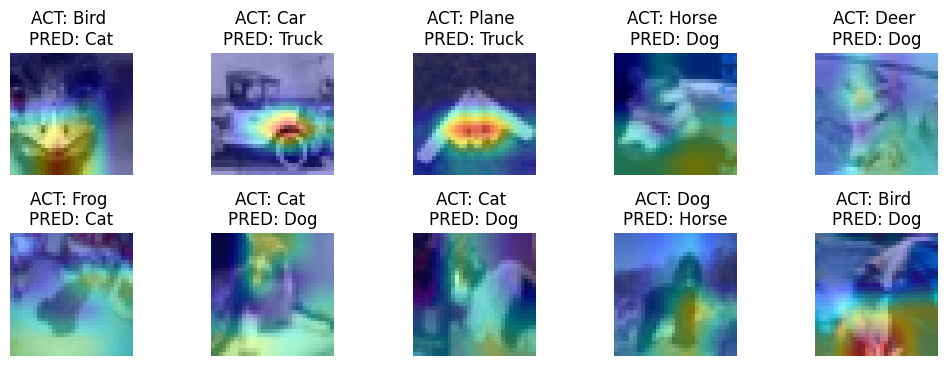

In [22]:
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3_r2[-1]],
    targets=None,
    num_images=10,
    image_weight=0.6,
)
plt.show()

In [ ]:
%load_ext tensorboard

!tensorboard --logdir {logging_path}

2024-04-25 07:15:25.031750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 07:15:25.031804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 07:15:25.033155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 07:15:26.005767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 